## Flowers Dataset

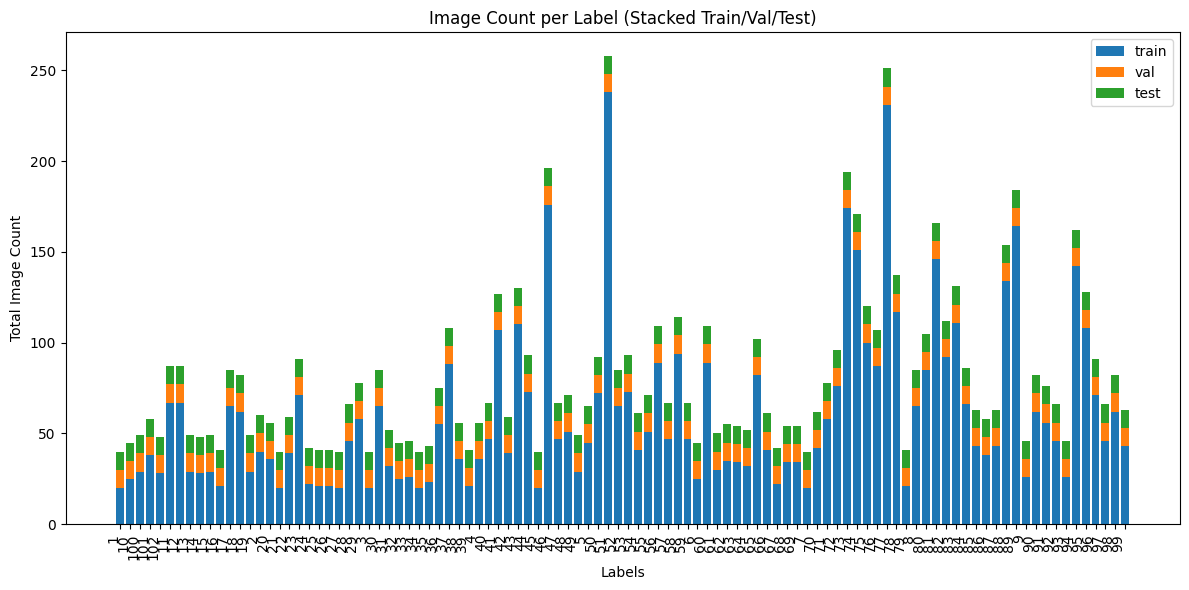

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# --- Config ---
dataset_root = Path("../dataset/oxford-flowers102")  # Update if needed
splits = ["train", "val", "test"]
colors = ["tab:blue", "tab:orange", "tab:green"]
image_exts = {".jpg", ".jpeg", ".png"}

# --- Count images per label per split ---
label_set = set()
split_counts = {split: {} for split in splits}

for split in splits:
    split_dir = dataset_root / split
    if split_dir.exists():
        for label_dir in split_dir.iterdir():
            if label_dir.is_dir():
                label = label_dir.name
                count = sum(1 for f in label_dir.glob("*") if f.suffix.lower() in image_exts)
                split_counts[split][label] = count
                label_set.add(label)

# --- Prepare data ---
labels = sorted(label_set)
counts_stacked = [ [split_counts[split].get(label, 0) for label in labels] for split in splits ]

# --- Plot stacked bar chart ---
x = np.arange(len(labels))
plt.figure(figsize=(12, 6))

bottom = np.zeros(len(labels))
for split, color, counts in zip(splits, colors, counts_stacked):
    plt.bar(x, counts, bottom=bottom, label=split, color=color)
    bottom += np.array(counts)

plt.xticks(x, labels, rotation=90, ha='right')
plt.ylabel("Total Image Count")
plt.xlabel("Labels")
plt.title("Image Count per Label (Stacked Train/Val/Test)")
plt.legend()
plt.tight_layout()
plt.show()

## Cosine with Linear warmup LR Schedule

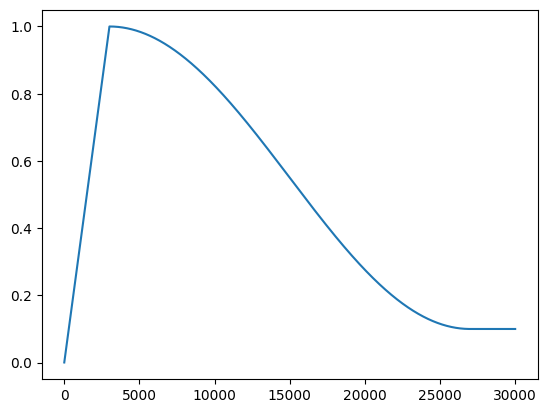

In [2]:
import math

min_lr_pct = 0.1
warmup_pct = 0.1
decay_step_pct = 0.8
n_epochs = 100
steps_per_epoch = 300
total_steps = n_epochs * steps_per_epoch
warmup_steps = int(warmup_pct * total_steps)
decay_steps = warmup_steps + int(decay_step_pct * total_steps)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step + 1) / float(max(1, warmup_steps))
    elif current_step > decay_steps:
        return min_lr_pct
    else:
        progress = float(current_step - warmup_steps) / float(max(1, decay_steps - warmup_steps))
        cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
    return min_lr_pct + (1 - min_lr_pct) * cosine_decay

x = np.arange(total_steps)
y = [ lr_lambda(s) for s in x ]
plt.plot(x, y);

In [ ]:
from torchvision import models
import sys
sys.path.append("..")
from model import ViTConfig, VisionTransformer
from omegaconf import OmegaConf
from pathlib import Path

model_map = {
    'ViT-B-16': models.vit_b_16,
    'ViT-B-32': models.vit_b_32,
    'ViT-L-16': models.vit_l_16,
    'ViT-L-32': models.vit_l_32,
    'ViT-H-14': models.vit_h_14,
}

yml_files = Path("../config/model").glob("*.yaml")
for yml_file in yml_files:
    cfg = OmegaConf.load(yml_file)
    cfg.img_size = 224
    cfg.img_chls = 3
    cfg.n_class = 1000
    name = cfg.name
    kwargs = dict(cfg)
    if name not in model_map:
        continue
    pt_model = model_map[name]()
    pt_params = sum(p.numel() for p in pt_model.parameters())
    model = VisionTransformer(ViTConfig(**kwargs))
    my_params = sum(p.numel() for p in model.parameters())
    print(f"{name=} {pt_params=:,} {my_params=:,}")
    assert pt_params == my_params, f"{name} failed"
print("\n\n\nSuccess!")

name='ViT-L/16' pt_params=304,326,632 my_params=304,326,632
name='ViT-H/14' pt_params=632,045,800 my_params=632,045,800
name='ViT-B/32' pt_params=88,224,232 my_params=88,224,232
name='ViT-L/32' pt_params=306,535,400 my_params=306,535,400
name='ViT-B/16' pt_params=86,567,656 my_params=86,567,656



Success!
